# Dataset of rented bikes on south korea

Dataset found at: [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand)

Also, I'm following the [Machine Learning for Everybody – Full Course by freeCodeCamp](https://www.youtube.com/watch?v=i_LwzRVP7bg)


## Imports


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

import requests

import os
import copy

from zipfile import ZipFile
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import RandomOverSampler

## Downloading the dataset


In [14]:
# Download the data from https://archive.ics.uci.edu/static/public/159/magic+gamma+telescope.zip
# and unzip it in the same directory as this notebook
file_name = 'bike-sharing.zip'

# @param {type:"string"}
request_url = 'https://archive.ics.uci.edu/static/public/560/seoul+bike+sharing+demand.zip'

should_download = False  # @param {type:"boolean"}

if should_download:
    request_data = requests.get(request_url)
    with open(file_name, 'wb') as f:
        f.write(request_data.content)

    with ZipFile(file_name, 'r') as zipObj:
        zipObj.extractall()

    # Delete the zip file
    os.remove(file_name)

# Result file name
result_file_name = 'SeoulBikeData.csv'

## Loading the data


In [15]:
# Column names
data_frame_cols = ["bike_count", "hour", "temp", "humidity", "wind",
                   "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]

data_frame_cols_drops = ["Date", "Holiday", "Seasons"]

# Load the dataset
data_frame = pd.read_csv(result_file_name).drop(data_frame_cols_drops, axis=1)
data_frame.columns = data_frame_cols

# Since computers are good at numbers, we will convert the categorical data into numbers
data_frame["functional"] = (data_frame["functional"] == "Yes").astype(int)

# Since our dataset is depending on time, we will shorten the dataset to only include the hour of 12
# Let's pretend that the hour is '12', then we'll drop the hour column
data_frame = data_frame[data_frame["hour"] == 12].drop("hour", axis=1)

# Also, lets drop wind, visibility and functional, since they are not important
data_frame = data_frame.drop(["wind", "visibility", "functional"], axis=1)

# data_frame.head()  # Uncomment to see the first 5 rows of the dataset

## Train, validation and test sets


In [16]:
train_dt, validation_dt, test_dt = np.split(data_frame.sample(
    frac=1), [int(.6*len(data_frame)), int(.8*len(data_frame))])

c:\Python311\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [17]:
# Function to get X and y from a dataframe
def get_labels(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)

    if x_labels is None:
        X = dataframe[[col for col in dataframe.columns if col != y_label]].values
    else:
        if (len(x_labels) == 1):
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_labels].values

    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, y))

    return data, X, y


"""
The code above does the following:
  1. Creates a deep copy of the dataframe, which is a copy that is not affected by changes to the original dataframe that we are passing in.
  2. Checks to see if x_labels is a null value. If it is, we create an array of all the columns in the dataframe except for the y label column.
      If it is not a null value, we check to see if there is a single label.
      If there is, we create a new array containing the values of that column.
      If there are multiple labels, we create an array of arrays containing the values of all the columns we want to use as features.
  3. Creates an array of the values of the y label column. This is the same as the code above, but we are not reshaping the array.
  4. Creates a new array that contains the values of the X array and the y array.
"""

'\nThe code above does the following:\n  1. Creates a deep copy of the dataframe, which is a copy that is not affected by changes to the original dataframe that we are passing in.\n  2. Checks to see if x_labels is a null value. If it is, we create an array of all the columns in the dataframe except for the y label column.\n      If it is not a null value, we check to see if there is a single label.\n      If there is, we create a new array containing the values of that column.\n      If there are multiple labels, we create an array of arrays containing the values of all the columns we want to use as features.\n  3. Creates an array of the values of the y label column. This is the same as the code above, but we are not reshaping the array.\n  4. Creates a new array that contains the values of the X array and the y array.\n'

## Linear regression


In [18]:
# 'Temp' here is the temperature feature we're using
_, X_train_temp, y_train_temp = get_labels(
    train_dt, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_labels(
    validation_dt, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_labels(
    test_dt, "bike_count", x_labels=["temp"])

In [19]:
temp_reg = LinearRegression().fit(X_train_temp, y_train_temp)

In [20]:
print("Training set score: {:.2f}".format(
    temp_reg.score(X_train_temp, y_train_temp)))

# Our training score is 0.30, which is not very good. Let's see if we can improve it by adding more features.

Training set score: 0.30


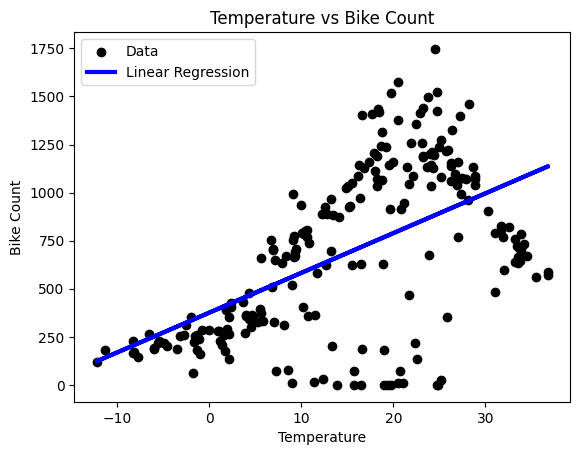

In [21]:
# Lets create a simple plot here to check the relationship between the temperature and the bike count
plt.scatter(X_train_temp, y_train_temp, color='black', label="Data")
plt.plot(X_train_temp, temp_reg.predict(
    X_train_temp), color='blue', linewidth=3, label="Linear Regression")
plt.xlabel("Temperature")
plt.ylabel("Bike Count")
plt.legend()
plt.title("Temperature vs Bike Count")
plt.show()

## Multiple linear regression


In [22]:
# Now, let's try to add more features to our model
train_dt, validation_dt, test_dt = np.split(data_frame.sample(
    frac=1), [int(.6*len(data_frame)), int(.8*len(data_frame))])

_, X_train_all, y_train_all = get_labels(
    train_dt, "bike_count", x_labels=data_frame.columns[1:])
_, X_val_all, y_val_all = get_labels(
    validation_dt, "bike_count", x_labels=data_frame.columns[1:])
_, X_test_all, y_test_all = get_labels(
    test_dt, "bike_count", x_labels=data_frame.columns[1:])

c:\Python311\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [23]:
all_reg = LinearRegression().fit(X_train_all, y_train_all)

In [24]:
print("Training set score: {:.2f}".format(
    all_reg.score(X_train_all, y_train_all)))

# Our training score is ~=0.50, which is better than before.

Training set score: 0.50


## Neural net with regression


### Neural net with Temperature feature only


In [62]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy Loss')
    ax1.legend()
    ax1.grid(True)

    plt.show()


temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(
    X_train_temp.reshape(-1)
)

In [33]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [34]:
temp_nn_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
history = temp_nn_model.fit(
    X_train_temp, y_train_temp,
    epochs=1000,
    verbose=1,
    validation_data=(X_val_temp, y_val_temp))

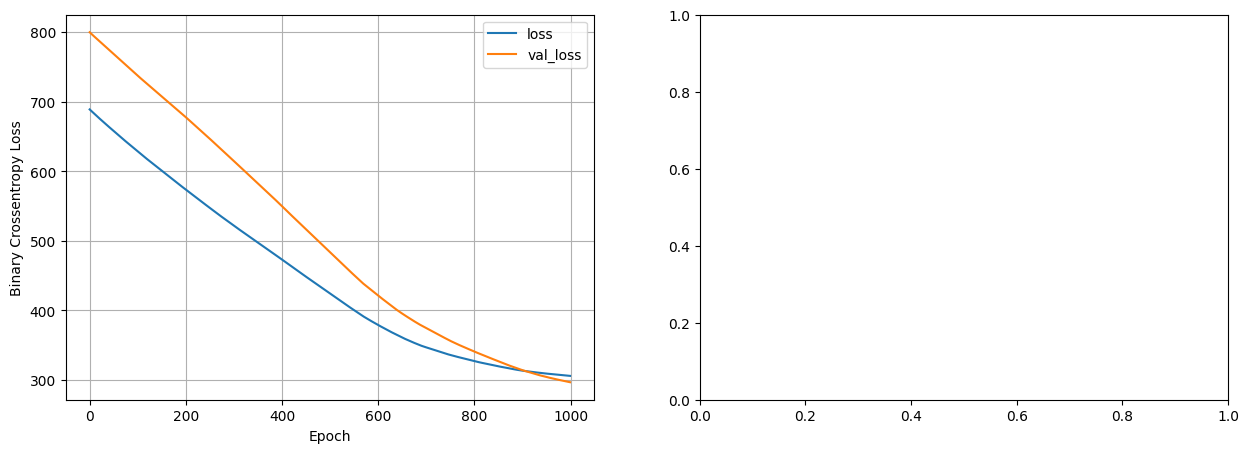

In [75]:
plot_history(history)

1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 1ms/step


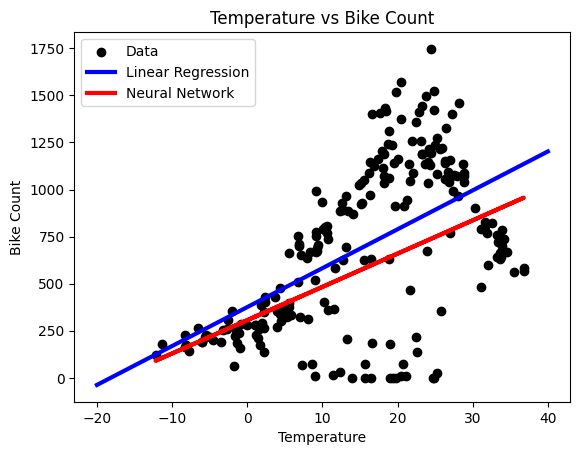

In [74]:
# Let's compare the plots of the linear regression model and the neural network model
plt.scatter(X_train_temp, y_train_temp, color='black', label="Data")
x = tf.linspace(-20, 40, 1000)
plt.plot(x, temp_reg.predict(
    np.array(x).reshape(-1, 1)
), color='blue', linewidth=3, label="Linear Regression")
plt.plot(X_train_temp, temp_nn_model.predict(
    X_train_temp), color='red', linewidth=3, label="Neural Network")
plt.xlabel("Temperature")
plt.ylabel("Bike Count")
plt.legend()
plt.title("Temperature vs Bike Count")
plt.show()

In [38]:
print("Training set score: {:.2f}".format(
    temp_nn_model.evaluate(X_train_temp, y_train_temp, verbose=0))
)

Training set score: 306.01


### Neural net with all features


In [45]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=None)
all_normalizer.adapt(
    X_train_all
)

In [46]:
all_nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(1)
])

In [47]:
all_nn_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')

In [48]:
all_history = all_nn_model.fit(
    X_train_all, y_train_all,
    epochs=1000,
    verbose=0,  # hide the output because it's too long
    validation_data=(X_val_all, y_val_all))

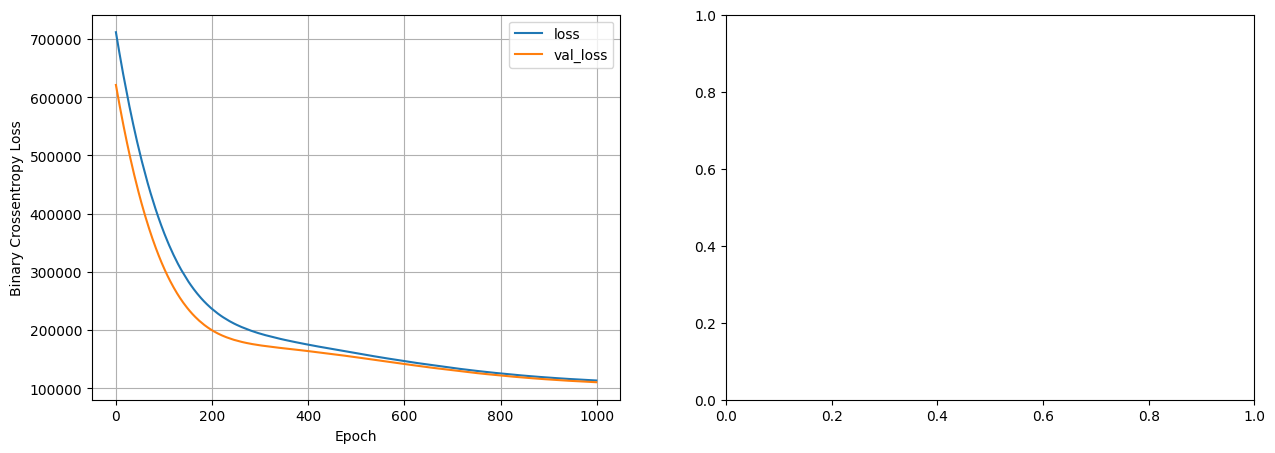

In [49]:
plot_history(all_history)

In [52]:
print("Training set score: {:.2f}".format(
    all_nn_model.evaluate(X_train_all, y_train_all, verbose=0))
)

Training set score: 113611.15


## Non linear neural net


In [99]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

neural_network = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    # relu is used here because we want to predict a positive number
    tf.keras.layers.Dense(1, activation='relu'),
])

neural_network.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error')

In [100]:
neural_network_history = neural_network.fit(
    X_train_all, y_train_all,
    epochs=1000,
    verbose=0,
    validation_data=(X_val_all, y_val_all))

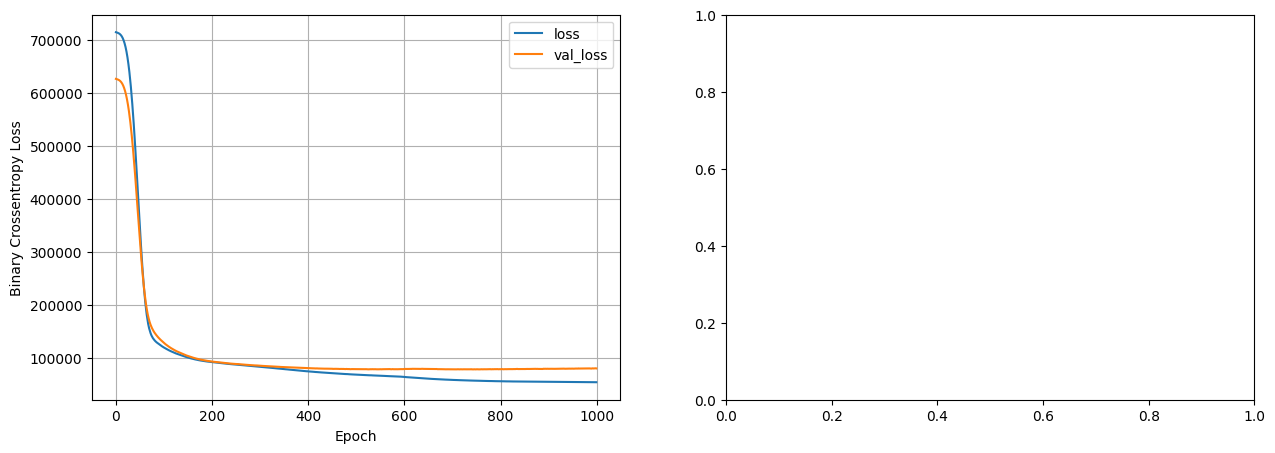

In [101]:
plot_history(neural_network_history)

In [105]:
# Function to calculate the MSE of a neural network
def get_nn_mse(model, X, y):
    return np.mean((model.predict(X) - y)**2)


print("Training set score: {:.2f}".format(
    get_nn_mse(neural_network, X_train_all, y_train_all)))
print("Validation set score: {:.2f}".format(
    get_nn_mse(neural_network, X_val_all, y_val_all)))
print("Test set score: {:.2f}".format(
    get_nn_mse(neural_network, X_test_all, y_test_all)))

7/7 [==============================] - 0s 827us/step
Training set score: 54163.12
3/3 [==============================] - 0s 1ms/step
Validation set score: 80264.63
3/3 [==============================] - 0s 999us/step
Test set score: 62146.19


3/3 [==============================] - 0s 2ms/step


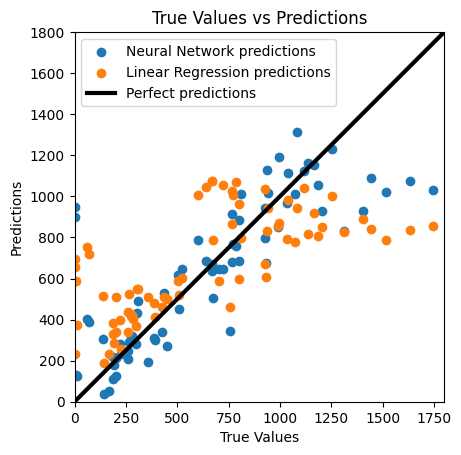

In [112]:
ax = plt.axes(aspect='equal')
plt.scatter(y_test_all, neural_network.predict(
    X_test_all), label="Neural Network predictions")
plt.scatter(y_test_all, all_nn_model.predict(X_test_all),
            label="Linear Regression predictions")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='black', linewidth=3,
             label="Perfect predictions")
plt.legend()
plt.title("True Values vs Predictions")
plt.show()